In [30]:
import numpy as np
import torch
from torch import nn
import pandas as pd
from torch.utils.data import DataLoader
from torchvision import models, transforms
from doodleLoaderSimple import DoodleDatasetSimple
from matplotlib import pyplot as plt
import seaborn as sns
from scipy.stats import chi2_contingency
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score


## Training and validation for the house image classifier

In [31]:
# Number to class labels mapping
class_dict = {
    0: 'Sad',
    1: 'Happy',
    2: 'Fear',
    3: 'Angry'
}

# Loading the data from the CSV file
data = np.genfromtxt(r'C:\Users\karti\Desktop\ML_NLP_project_COPY\data\colorData.csv', dtype=int, delimiter=',', names=True)

# Convert structured NumPy array to Pandas DataFrame
df = pd.DataFrame(data)


# Convert class labels
df['class_label'] = df['class'].map(class_dict)
df.head()

,id,class,class_label
0,0,0,Sad
1,1,0,Sad
2,2,0,Sad
3,3,0,Sad
4,4,0,Sad


In [32]:
# Check for missing values
print("Missing values:\n", df.isnull().sum())

# Check for duplicates
print("\nDuplicate rows:", df.duplicated().sum())

# Remove duplicates if any
df = df.drop_duplicates()

# Convert numeric class labels to their corresponding category
df['class_label'] = df['class'].map(class_dict)

# Display cleaned data
print(df.head())


Missing values:
 id             0
class          0
class_label    0
dtype: int64

Duplicate rows: 0
   id  class class_label
0   0      0         Sad
1   1      0         Sad
2   2      0         Sad
3   3      0         Sad
4   4      0         Sad


C:\Users\karti\AppData\Local\Temp\ipykernel_21744\1467783719.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='class_label', data=df, palette='viridis')


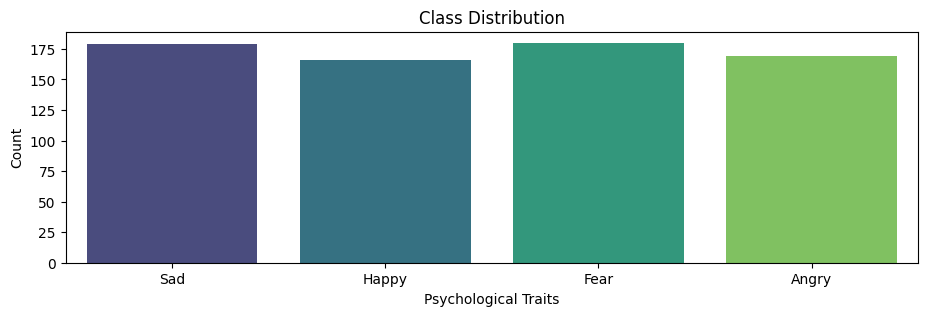

In [33]:
# Plot class distribution
plt.figure(figsize=(11, 3))
sns.countplot(x='class_label', data=df, palette='viridis')
plt.title("Class Distribution")
plt.xlabel("Psychological Traits")
plt.ylabel("Count")
plt.show()


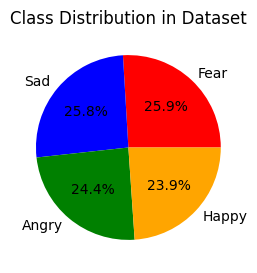

In [34]:
# Pie chart visualization
plt.figure(figsize=(3,3))
df['class_label'].value_counts().plot.pie(autopct='%1.1f%%', colors=['red', 'blue', 'green', 'orange'])
plt.title("Class Distribution in Dataset")
plt.ylabel("")
plt.show()


In [35]:
def count_classes(dictClass, arr):
    
    unique, count = numpy.unique(arr, return_counts=True)
    print(dict(zip(dictClass.values(), count)))
    count = 1 / count
    count = count / sum(count)
    return count

In [36]:
# Match the image IDs to the ID values in the .csv file.
image_extensions = ['png', 'jpg', 'jpeg', 'bmp', 'gif', 'tiff', 'webp']

translation_dict = {
    f"{id}.{ext}": cls
    for id, cls in zip(data['id'], data['class'])
    for ext in image_extensions
}


# Prepare each image to be passed as a Tensor product to the model.
data_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((224, 224)),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Prepare the data by matching it to its label and transforming it to a Tensor product.
housedata = DoodleDatasetSimple(r'C:\Users\karti\Desktop\ML_NLP_project_COPY\images\color', data_transforms, translation_dict)


In [37]:
import torch
import math
from torch.utils.data import random_split, DataLoader

# Step 1: Shuffle housedata before splitting
generator = torch.Generator().manual_seed(42)  # Ensures reproducibility
train_len = math.floor(len(housedata) * 0.8)
test_len = len(housedata) - train_len

# Step 2: Perform the split with shuffling
train_set, val_set = random_split(housedata, [train_len, test_len], generator=generator)

# Step 3: Load datasets into DataLoaders
train_loader = DataLoader(train_set, batch_size=4, shuffle=True, num_workers=0, drop_last=True)
test_loader = DataLoader(val_set, batch_size=4, shuffle=False, num_workers=0, drop_last=True)  # No need to shuffle test set


In [38]:
from collections import Counter
train_classes = [housedata[i]['class'] for i in train_set.indices]
val_classes = [housedata[i]['class'] for i in val_set.indices]
print("Train class distribution:", Counter(train_classes))
print("Validation class distribution:", Counter(val_classes))


Train class distribution: Counter({np.int64(2): 152, np.int64(3): 140, np.int64(0): 137, np.int64(1): 126})
Validation class distribution: Counter({np.int64(0): 42, np.int64(1): 40, np.int64(3): 29, np.int64(2): 28})


## Model Definition

In [39]:
class MultilabelClassifier(nn.Module):
    """
    Class that contains the layers for the model.
    Starting model ResNet-34, replace last layer with a Linear layer that outputs
    a single number, the label of the image.
    """
    def __init__(self, n_features):
        super().__init__()
        self.resnet = models.resnet34(pretrained=True)
        self.model_wo_fc = nn.Sequential(*(list(self.resnet.children())[:-1]))

        self.imageClass = nn.Sequential(
            nn.Dropout(p=0.2),
            nn.Linear(in_features=512, out_features=n_features)
        )

    def forward(self, x):
        x = self.model_wo_fc(x)
        x = torch.flatten(x, 1)

        return {
            'class': self.imageClass(x)
        }
    



In [40]:
# Set the device to use as the GPU if there is compatible hardware
# Otherwise run the model on the cpu
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = MultilabelClassifier(4).to(device)


c:\Users\karti\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\karti\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [41]:
def criterion(outputs, pictures):
    """
    Method used by the model as the criterion for training.
    Cross entropy loss used as the loss function
    :param outputs: Predicted labels by the model
    :param pictures: Actual labeled images from the dataset
    :return: The sum of the cross entropy loss function.
    """
    losses = 0
    loss_func = nn.CrossEntropyLoss()  # Define once outside loop

    labelsTensor = pictures['class'].to(device).long()  # Move labels to device once

    for key in outputs:
        losses += loss_func(outputs[key], labelsTensor)

    return losses



In [42]:
import os
import torch

def training(model, device, lr_rate, epochs, train_loader):
    torch.cuda.empty_cache()  # Clear cache before training

    num_epochs = epochs
    losses = []
    checkpoint_losses = []

    optimizer = torch.optim.Adam(model.parameters(), lr=lr_rate)
    n_total_steps = len(train_loader)

    for epoch in range(num_epochs):
        for i, pictures in enumerate(train_loader):
            images = pictures['image'].to(device, dtype=torch.float32)  # Ensure correct dtype
            labels = pictures['class'].to(device)  # Move labels correctly

            output = model(images)

            loss = criterion(output, {'class': labels})  # Use correct labels
            losses.append(loss.item())

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            if (i + 1) % 100 == 0:  # Free memory every 100 steps
                torch.cuda.empty_cache()

            if (i + 1) % (int(n_total_steps / 1)) == 0:
                checkpoint_loss = torch.tensor(losses).mean().item()
                checkpoint_losses.append(checkpoint_loss)
                print(f'Epoch [{epoch + 1}/{num_epochs}], Step [{i + 1}/{n_total_steps}], Loss: {checkpoint_loss:.4f}')

    model_save_path = r'C:\Users\karti\Desktop\ML_NLP_project_COPY\model\color\color_model_20.tar'
    
    # Ensure directory exists before saving
    save_dir = os.path.dirname(model_save_path)
    if not os.path.exists(save_dir):
        print(f"Creating directory: {save_dir}")
        os.makedirs(save_dir, exist_ok=True)

    # Save the model
    try:
        torch.save({
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': checkpoint_losses,
        }, model_save_path)
        print(f"Model successfully saved at {model_save_path}")
    except Exception as e:
        print(f"Error saving model: {e}")

    return checkpoint_losses


In [43]:
# Call the method to train the model
checkpoint_losses = training(model, device, 0.0001, 20, train_loader)


Epoch [1/20], Step [138/138], Loss: 1.2411
Epoch [2/20], Step [138/138], Loss: 1.0583
Epoch [3/20], Step [138/138], Loss: 0.8848


KeyboardInterrupt: 

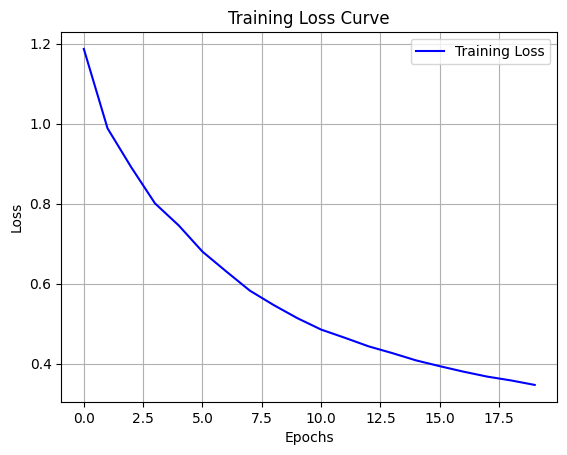

In [ ]:
plt.plot(checkpoint_losses, linestyle='-', color='b', label='Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss Curve')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
def validation(model, dataloader, device):
    """
    Validates the model after training.

    :param model: The trained model.
    :param dataloader: Dataloader providing labeled images in batches.
    :param device: Device (CPU or GPU) for computation.
    :return: Model accuracy in percentage.
    """
    model.eval()  # Set model to evaluation mode
    n_correct = 0
    n_samples = 0

    with torch.no_grad():
        for pictures in dataloader:
            images = pictures['image'].to(device)
            labels = pictures['class'].to(device)

            outputs = model(images)['class']  # Extract class predictions
            _, predicted = torch.max(outputs, 1)  # Get predicted class indices

            n_correct += (predicted == labels).sum().item()
            n_samples += labels.size(0)

    acc = 100.0 * n_correct / n_samples if n_samples > 0 else 0.0  # Avoid division by zero
    print(f"Validation Accuracy: {acc:.2f}%")
    
    return acc


In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)  # Move model to device

# Call the validation function
accuracy = validation(model, test_loader, device)

Validation Accuracy: 60.29%


In [ ]:
y_true = []  # Store actual labels
y_pred = []  # Store model predictions

model.eval()
with torch.no_grad():
    for pictures in test_loader:
        images = pictures['image'].to(device)
        labels = pictures['class'].to(device)

        outputs = model(images)['class']  # Extract class predictions
        _, predicted = torch.max(outputs, 1)  # Convert logits to class indices

        y_true.extend(labels.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())

# Compute metrics
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, average="weighted")
recall = recall_score(y_true, y_pred, average="weighted")
f1 = f1_score(y_true, y_pred, average="weighted")


print("Sample y_true:", y_true[:10])  # First 10 actual labels
print("Sample y_pred:", y_pred[:10])  # First 10 predicted labels

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")


Sample y_true: [np.int64(0), np.int64(3), np.int64(0), np.int64(3), np.int64(3), np.int64(3), np.int64(1), np.int64(0), np.int64(1), np.int64(2)]
Sample y_pred: [np.int64(1), np.int64(2), np.int64(2), np.int64(2), np.int64(2), np.int64(2), np.int64(1), np.int64(0), np.int64(1), np.int64(0)]
Accuracy: 0.6029
Precision: 0.6642
Recall: 0.6029
F1 Score: 0.6118
